In [21]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
import random

from tqdm import tqdm

from xgboost import XGBRegressor, XGBRanker
#from sklearn.xgboost import XGBRegressor

from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor, HistGradientBoostingClassifier, AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, ndcg_score
from sklearn.utils import resample
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, GroupKFold
import lightgbm

In [22]:
# data = pd.read_csv('data/train_train.csv')

train_data = pd.read_csv('data/train_train_FE.csv')
train_data.drop('Unnamed: 0', axis=1, inplace=True)

train_data.drop('date_time', axis = 1, inplace=True)
#train_data.drop('prob_searchclick', axis = 1, inplace=True)

train_data['target'] = train_data['click_bool'] + 4* train_data['booking_bool']
train_data['target'].loc[train_data['target'].isna()] = int(0)

/var/folders/z9/j9843dsj2t5dsl2bv81xcwww0000gn/T/ipykernel_47924/3448730126.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['target'].loc[train_data['target'].isna()] = int(0)


In [23]:
test_data = pd.read_csv('data/train_test_FE.csv')
test_data.drop('Unnamed: 0', axis=1, inplace=True)

test_data.drop('date_time', axis = 1, inplace=True)
test_data['target'] = test_data['click_bool'] + 4* test_data['booking_bool']
test_data['target'].loc[test_data['target'].isna()] = int(0)

/var/folders/z9/j9843dsj2t5dsl2bv81xcwww0000gn/T/ipykernel_47924/970696445.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['target'].loc[test_data['target'].isna()] = int(0)


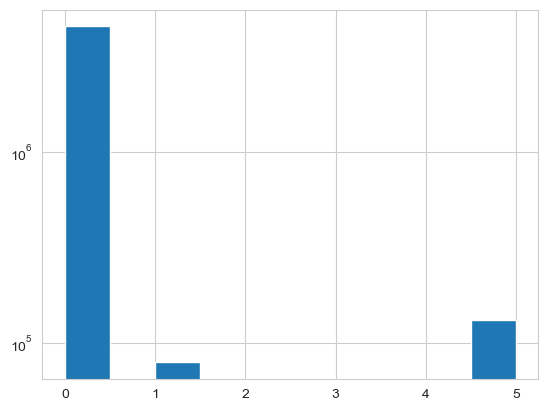

In [24]:
train_data['target'].hist()
plt.yscale('log')

In [25]:
# data.sort_values(['srch_id', 'target'], axis=0, inplace=True, ignore_index=True, ascending=[True, False])
# ids = data['srch_id'].unique()

In [26]:
# train_ids = random.sample(list(ids), k = int(0.95* len(ids)))
# test_ids = set(ids) - set(train_ids)

In [27]:
# data = data.join(data.loc[data['srch_id'].isin(train_ids)].groupby('prop_id')['booking_bool'].mean(), on = 'prop_id', rsuffix = '_mean')
# data = data.join(data.loc[data['srch_id'].isin(train_ids)].groupby('prop_id')['click_bool'].mean(), on = 'prop_id', rsuffix = '_mean')

In [28]:
# train_data = data.loc[data['srch_id'].isin(train_ids)]
# test_data = data.loc[data['srch_id'].isin(test_ids)]

In [29]:
# # get search ids with any booking
# ids_train = train_data['srch_id'].loc[train_data['booking_bool'] == 1].unique()
# # use only the searches that resulted in a booking
# train_data = train_data.loc[train_data['srch_id'].isin(ids)]
# # only use properties that are being booked
# props = train_data['prop_id'].loc[train_data['booking_bool'] == 1].unique()
# data = train_data.loc[train_data['prop_id'].isin(props)]

In [31]:
#undersample non bookings
X_under, y_under = resample(train_data.drop([ 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
                                      , axis=1).loc[train_data['target'] < 1], train_data['target'].loc[train_data['target'] < 1]
                                      , n_samples= 1* sum(train_data['target'] >= 1), replace=False)

In [32]:
# X_bal = pd.concat([X_under, train_data.drop(['true_rank', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
#                                       , axis=1).loc[train_data['target'] >= 1]])

# y_bal = y_under
# y_bal = y_bal.append(train_data['target'].loc[train_data['target'] >= 1])

X_bal = train_data.drop(['click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target'], axis=1)
y_bal = train_data['target']


(array([4500955.,       0.,   79241.,       0.,       0.,       0.,
              0.,       0.,       0.,  131528.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

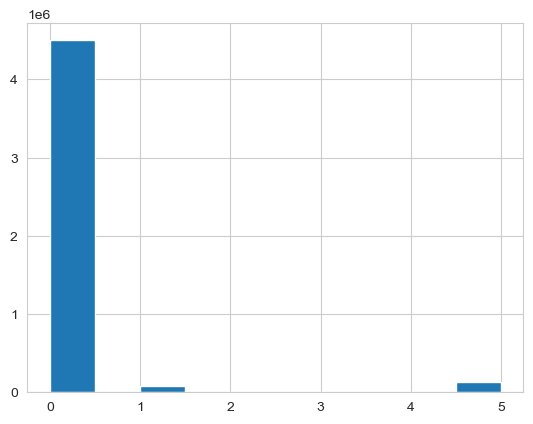

In [33]:
plt.hist(y_bal)

In [34]:
# X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal)

# X_train, X_test, y_train, y_test = train_test_split(data.drop(['booking_bool_mean', 'click_bool_mean', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
#                                        , axis=1), data['target'])
#X_train, y_train = X_bal, y_bal

In [35]:
# much better than just replacing with 0
# X_train = X_train.fillna(-9999)
# baseline = GradientBoostingRegressor(n_estimators = 100, max_leaf_nodes=None, max_depth=3, random_state=42)

#baseline = HistGradientBoostingRegressor(random_state=42)
#baseline = GradientBoostingRegressor(random_state=42)
#baseline = AdaBoostRegressor(random_state=42)

#baseline = XGBRegressor(n_estimators = 500, random_state = 42, objective= 'rank:ndcg@5')

# baseline = XGBRanker(n_estimators = 100, random_state = 42, objective= 'rank:ndcg', eval_metric = 'ndcg@5-')

In [52]:
baseline = lightgbm.LGBMRanker(
        objective="rank_xendcg",
        metric="ndcg",
        n_estimators=2, # 2000
        learning_rate=0.08,
        max_position=5,
        random_state=42,
        seed=42,
        boosting="dart",
    )

In [53]:
# clf_x.fit(
#     X = X_train,
#     y = y_train,
#     group = qids_train,
#     eval_set=[(X_val, y_val)],
#     eval_group=[qids_val],
#     verbose=10,
# )

In [54]:
X_bal.columns

Index(['srch_id', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'co

In [55]:
X_bal.drop(columns="Unnamed: 0.1", inplace=True)

KeyError: "['Unnamed: 0.1'] not found in axis"

In [56]:
groups = X_bal.groupby('srch_id').size().to_frame('size')['size'].to_numpy()
baseline.fit(X_bal.drop(['srch_id'], axis = 1),y_bal, group = groups)


LGBMRanker(boosting='dart', learning_rate=0.08, max_position=5, metric='ndcg',
           n_estimators=2, objective='rank_xendcg', random_state=42, seed=42)

In [36]:
# hyper param tuning
# param_dist = {'min_samples_split' : [2, 10_000], 'max_depth' : [3, 15]}
# hp_search = HalvingRandomSearchCV(baseline, param_dist, min_resources=50_000).fit(X_train, y_train)

In [ ]:
raise KeyboardInterrupt

In [37]:
# hp_search.best_params_

In [38]:
# groups = X_bal.groupby('srch_id').size().to_frame('size')['size'].to_numpy()

# baseline.fit(X_bal.drop(['srch_id'], axis = 1),y_bal, group = groups)


KeyboardInterrupt



In [ ]:
# pred = baseline.predict(data.drop(['srch_id', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target'], axis=1).fillna(-9999))

In [ ]:
#mean_squared_error(data['target'], pred)

In [ ]:
# pred_test = baseline.predict(X_test.drop(['srch_id'], axis=1).fillna(-9999))
# print('MSE', mean_squared_error(y_test, pred_test))

# score = score_predict(X_test, y_test, pred_test)
# print('score', score)

In [62]:
print(np.setdiff1d(test_data.columns,X_bal.columns))

['Unnamed: 0.1' 'booking_bool' 'click_bool' 'gross_bookings_usd'
 'in_train' 'position' 'target']


Index(['Unnamed: 0.1', 'srch_id', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_ra

In [65]:
test_data['pred_score'] = baseline.predict(test_data.drop(['srch_id', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target',"Unnamed: 0.1","in_train"]
                                      , axis=1).fillna(-9999))


In [66]:
print('MSE', mean_squared_error(test_data['target'], test_data['pred_score']))

MSE 0.7152357036936535


In [67]:
test_data['pred_rank'] = test_data.groupby('srch_id')['pred_score'].rank(ascending=False).astype(int)
test_ids = test_data["srch_id"].unique()

In [69]:
# scoring with ndcg
mean_ndcg = 0
counter = 0
for id in tqdm(test_ids):
    if len(test_data['target'].loc[test_data['srch_id'] == id]) > 1:
        ndcg = ndcg_score([test_data['target'].loc[test_data['srch_id'] == id].astype(int).to_numpy()],
                        [test_data['pred_score'].loc[test_data['srch_id'] == id].to_numpy()], k = 5)

    mean_ndcg += ndcg
    if ndcg < 1.0:
        counter +=1

mean_ndcg = mean_ndcg/len(test_ids)

100%|██████████| 9990/9990 [00:31<00:00, 318.34it/s]


In [70]:
mean_ndcg

0.21453537721519927

In [ ]:
plt.bar(range(len(baseline.feature_importances_)), baseline.feature_importances_)
plt.figsize= (4,20)
# plt.xlabel(baseline.get_booster().feature_names, rotation = 90)
plt.xticks(range(len(baseline.feature_importances_)), baseline.get_booster().feature_names,rotation = 90)
plt.tight_layout()
plt.show()


## Predict the test dataset and bring it into requested format

In [ ]:
comp_data = pd.read_csv('data/FE_test_set.csv')
comp_data.drop('Unnamed: 0', axis=1, inplace=True)

# test_data = pd.read_csv('data/test_set_VU_DM.csv')
comp_data.drop('date_time', axis = 1, inplace=True)

In [ ]:
comp_data.head()

In [ ]:
set(comp_data.columns) - set(baseline.get_booster().feature_names)

In [ ]:
comp_data['prediction'] = baseline.predict(comp_data.drop(['srch_id', 'in_train'], axis=1).fillna(-9999))

# test_data['prediction'] = baseline.predict(test_data.drop(['srch_id', 'date_time'], axis=1).fillna(-9999))

In [ ]:
# sort values for final format
comp_data.sort_values(['srch_id', 'prediction'], axis=0, inplace=True, ignore_index=True, ascending=[True, False])

In [ ]:
filename = 'data/predictions/prediction'+str(datetime.now())+'.csv'
comp_data[['srch_id', 'prop_id']].to_csv(filename, index=False)